# Initialisation

In [48]:
import sys, os, warnings, json, joblib
warnings.filterwarnings('ignore')

sys.path.append('..')    
from datetime import datetime
import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
from scipy.stats import ks_2samp, chi2_contingency, pearsonr, spearmanr

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, \
                            mean_absolute_percentage_error

from config.parameters import DATA_CONFIG, MODEL_CONFIG, EDA_CONFIG
from src.model import load_drift_data, prepare_validation_lightgbm, load_data


plt.rcParams['figure.figsize'] = EDA_CONFIG['figsize']

print(f"Notebook dérive – lancé : {datetime.now():%Y-%m-%d %H:%M:%S}")


Notebook dérive – lancé : 2025-07-07 16:48:33


# CHARGEMENT DU MODÈLE ET DES DONNÉES DRIFT

In [49]:

best_model = joblib.load('../models/lgbm_model.pkl')

# Charger les données drift
X_drift, ids_drift = load_drift_data()
y_drift = X_drift.pop(DATA_CONFIG['target_column'])

# Détecter le type de modèle correctement
model_type = type(best_model).__name__
print(f"Type de modèle détecté: {model_type}")

# Preprocessing selon le type de modèle
if 'LGBM' in model_type or 'LightGBM' in model_type:
    print("Preprocessing pour LightGBM...")

    # Pour LightGBM, on doit encoder les variables catégorielles
    X_drift_pp = prepare_validation_lightgbm(X_drift, X_drift)
elif hasattr(best_model, 'named_steps'):
    print("Preprocessing pour GLM...")
    # Pour Pipeline GLM
    X_drift_pp = best_model.named_steps['preprocessor'].transform(X_drift)
else:
    print("Type de modèle non reconnu, utilisation des données brutes")
    X_drift_pp = X_drift

print(f"Données drift : {X_drift.shape} → {X_drift_pp.shape if hasattr(X_drift_pp, 'shape') else 'Pipeline'}")
print(f"Modèle chargé : {model_type}")


Colonnes supprimées : ['CodeProfession', 'PolicyId', 'StatutMatrimonial']
Type de modèle détecté: LGBMRegressor
Preprocessing pour LightGBM...
Encodage des variables catégorielles pour validation: ['SexeConducteur', 'FrequencePaiement', 'ClasseVehicule', 'PuissanceVehicule', 'CarburantVehicule', 'UsageVehicule', 'Garage', 'Region']
Données drift : (22481, 11) → (22481, 11)
Modèle chargé : LGBMRegressor


# PERFORMANCE ACTUELLE 

In [50]:
# Prédictions sur les données drift
y_pred_drift = best_model.predict(X_drift_pp)

metrics_drift = {
    'RMSE': np.sqrt(mean_squared_error(y_drift, y_pred_drift)),
    'MAE' : mean_absolute_error(y_drift, y_pred_drift),
    'R²'  : r2_score(y_drift, y_pred_drift),
    'MAPE': mean_absolute_percentage_error(y_drift, y_pred_drift)*100
}

# Charger les métriques originales (à adapter selon votre sauvegarde)
try:
    # Essayer de charger depuis JSON
    with open('../models/model_performance.json', 'r') as f:
        perf_data = json.load(f)
        # Adapter selon la structure de votre JSON
        if 'models_performance' in perf_data:
            metrics_initial = perf_data['models_performance'].copy()

            if 'R2' in metrics_initial:
                metrics_initial['R²'] = metrics_initial.pop('R2')
        else:
            metrics_initial = perf_data

except FileNotFoundError:
    # Valeurs de référence si pas de fichier sauvegardé
    print("Fichier de performance non trouvé")

# Affichage comparatif
comparison_df = pd.DataFrame([metrics_initial, metrics_drift],
                           index=['Initial', 'Drift']).round(2)
print("=== COMPARAISON DES PERFORMANCES ===")
display(comparison_df)

# Calcul des dégradations
print("\n=== DÉGRADATION DES MÉTRIQUES ===")
for metric in ['RMSE', 'MAE', 'R²']:
    if metric in metrics_initial and metric in metrics_drift:
        initial_val = metrics_initial[metric]
        drift_val = metrics_drift[metric]
        
        if metric == 'R²':
            # Pour R², une diminution est mauvaise
            change = ((drift_val - initial_val) / initial_val) * 100
        else:
            # Pour RMSE/MAE, une augmentation est mauvaise
            change = ((drift_val - initial_val) / initial_val) * 100
        
        print(f"{metric}: {initial_val:.2f} → {drift_val:.2f} ({change:+.1f}%)")
    else:
        print(f"Métrique {metric} manquante dans l'un des datasets")

=== COMPARAISON DES PERFORMANCES ===


,RMSE,MAE,MAPE,R²
Initial,107.91,73.40,17.98,0.75
Drift,266.62,214.09,43.90,-0.35



=== DÉGRADATION DES MÉTRIQUES ===
RMSE: 107.91 → 266.62 (+147.1%)
MAE: 73.40 → 214.09 (+191.7%)
R²: 0.75 → -0.35 (-147.2%)


# GRAPHIQUES COMPARATIFS 

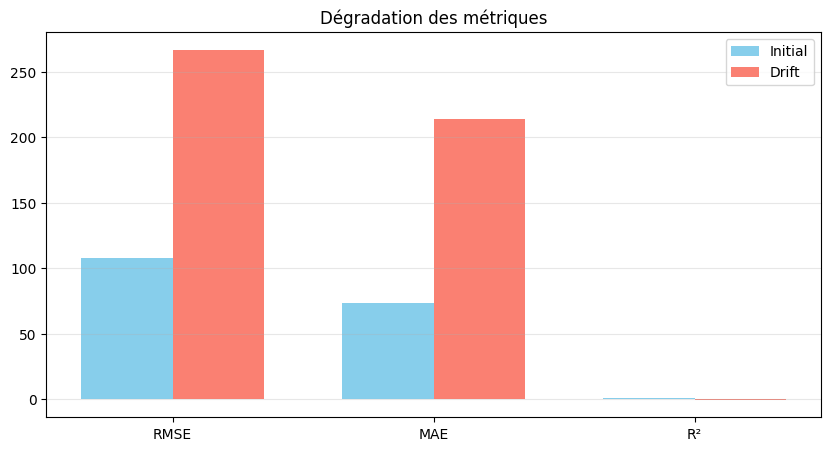

In [51]:
labels = list(metrics_drift.keys())[:-1]      # sans MAPE pour l’axe
init_vals = [metrics_initial[k] for k in labels]
drft_vals = [metrics_drift[k]   for k in labels]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10,5))
ax.bar(x-width/2, init_vals, width, label='Initial', color='skyblue')
ax.bar(x+width/2, drft_vals, width, label='Drift',   color='salmon')
ax.set_xticks(x); ax.set_xticklabels(labels)
ax.set_title('Dégradation des métriques')
ax.legend(); ax.grid(True, axis='y', alpha=.3)
plt.show()


# TEST DRIFT SUR VARIABLES EXPLICATIVES 

In [52]:
print("=== ANALYSE DU DRIFT DES VARIABLES ===")

# Charger les données d'entraînement pour comparaison
X_train_raw = pd.read_csv(os.path.join("..", DATA_CONFIG['raw_data_path'], DATA_CONFIG['train_file']))
if DATA_CONFIG['target_column'] in X_train_raw.columns:
    y_train_raw = X_train_raw.pop(DATA_CONFIG['target_column'])
if DATA_CONFIG['id_column'] in X_train_raw.columns:
    X_train_raw = X_train_raw.drop(DATA_CONFIG['id_column'], axis=1)

drift_report = []

print(f"Analyse du drift sur {len(X_drift.columns)} variables...")

for col in X_drift.columns:
    if col in X_train_raw.columns:
        try:
            if X_drift[col].dtype == 'object':  # Variables catégorielles
                # Test du Chi2
                # Créer un tableau de contingence
                combined_data = pd.concat([
                    pd.DataFrame({'value': X_train_raw[col], 'dataset': 'train'}),
                    pd.DataFrame({'value': X_drift[col], 'dataset': 'drift'})
                ])
                
                ct = pd.crosstab(combined_data['value'], combined_data['dataset'])
                if ct.shape[0] > 1 and ct.shape[1] > 1:
                    chi2, p, *_ = chi2_contingency(ct)
                    drift_report.append((col, 'chi2', p, 'categorical'))
                else:
                    drift_report.append((col, 'chi2', 1.0, 'categorical'))
                    
            else:  # Variables numériques
                # Test de Kolmogorov-Smirnov
                stat, p = ks_2samp(X_train_raw[col].dropna(), X_drift[col].dropna())
                drift_report.append((col, 'ks', p, 'numerical'))
                
        except Exception as e:
            print(f"Erreur pour {col}: {str(e)[:50]}...")
            drift_report.append((col, 'error', 1.0, 'error'))

# Créer le rapport
drift_df = pd.DataFrame(drift_report, columns=['Variable', 'Test', 'p_value', 'Type'])
drift_df['Drift_Detected'] = drift_df['p_value'] < 0.05
drift_df = drift_df.sort_values('p_value')

print(f"\n=== RÉSULTATS DU DRIFT ===")
print(f"Variables avec drift significatif (p < 0.05): {drift_df['Drift_Detected'].sum()}/{len(drift_df)}")

display(drift_df.head(15))

# Résumé par type
drift_summary = drift_df.groupby(['Type', 'Drift_Detected']).size().unstack(fill_value=0)
if not drift_summary.empty:
    display(drift_summary)

=== ANALYSE DU DRIFT DES VARIABLES ===
Analyse du drift sur 11 variables...

=== RÉSULTATS DU DRIFT ===
Variables avec drift significatif (p < 0.05): 5/11


,Variable,Test,p_value,Type,Drift_Detected
0,AgeConducteur,ks,0.0,numerical,True
2,BonusMalus,ks,0.0,numerical,True
3,FrequencePaiement,chi2,0.0,categorical,True
4,AgeVehicule,ks,0.0,numerical,True
5,ClasseVehicule,chi2,0.0,categorical,True
1,SexeConducteur,chi2,1.0,categorical,False
6,PuissanceVehicule,chi2,1.0,categorical,False
7,CarburantVehicule,chi2,1.0,categorical,False
8,UsageVehicule,chi2,1.0,categorical,False
9,Garage,chi2,1.0,categorical,False


Drift_Detected,False,True
Type,,
categorical,6,2
numerical,0,3


# ANALYSE DES CHANGEMENTS DE CORRÉLATION 

In [53]:
# Filtrer numériques
num_train = X_train_raw.select_dtypes(include=['int64','float64'])
num_drift = X_drift.select_dtypes(include=['int64','float64'])

# Vérifier tailles
print(f"  • Train numériques: {num_train.shape}")
print(f"  • Drift numériques: {num_drift.shape}")

# Calcul corrélations Spearman
corr_train = num_train.corrwith(y_train_raw, method='spearman').dropna()
corr_drift = num_drift.corrwith(y_drift,       method='spearman').dropna()

common = corr_train.index.intersection(corr_drift.index)
print(f"Variables numériques communes: {len(common)}")

# Calcul des deltas
corr_delta = (corr_drift[common] - corr_train[common]).sort_values(key=abs, ascending=False)

# Top 10
top10 = corr_delta.head(10).index
corr_changes = pd.DataFrame({
    'Train_Corr': corr_train[top10].round(3),
    'Drift_Corr': corr_drift[top10].round(3),
    'Delta'     : corr_delta[top10].round(3)
})
display(corr_changes)

# Changements significatifs
signif = corr_delta[abs(corr_delta) > 0.1]
print(f"\nChangements significatifs (|Δ|>0.1): {len(signif)}")
for var, delta in signif.items():
    print(f"  {var}: Δ={delta:+.3f}")


  • Train numériques: (22481, 3)
  • Drift numériques: (22481, 3)
Variables numériques communes: 3


,Train_Corr,Drift_Corr,Delta
AgeVehicule,-0.549,-0.175,0.373
BonusMalus,0.360,0.115,-0.244
AgeConducteur,-0.214,-0.178,0.036



Changements significatifs (|Δ|>0.1): 2
  AgeVehicule: Δ=+0.373
  BonusMalus: Δ=-0.244


# Conclusion de l'analyse

### **Dégradation des performances**
- **RMSE** : 108€ → 267€ (**+147%**)
- **MAE** : 73€ → 214€ (**+192%**)  
- **R²** : 0.75 → -0.35 (**-147%**)
- **MAPE** : 17.98 → 43.9%

Le coefficient de détermination **négatif** (-0.35) indique que le modèle performe désormais **moins bien qu'une simple moyenne**, révélant une inadéquation majeure aux nouvelles données.

## **Analyse du drift des variables explicatives**

### **Variables impactées (5/11 - 45%)**

**Variables numériques (100% touchées) :**
- **AgeConducteur** (KS test, p=0.0) : Distribution des âges modifiée
- **BonusMalus** (KS test, p=0.0) : Profil de risque des conducteurs évoluué  
- **AgeVehicule** (KS test, p=0.0) : Parc automobile rajeuni

**Variables catégorielles (25% touchées) :**
- **FrequencePaiement** (Chi², p=0.0) : Habitudes de paiement modifiées
- **ClasseVehicule** (Chi², p=0.0) : Types de véhicules assurés différents

### **Variables stables (6/11 - 55%)**
- Variables démographiques et géographiques restent cohérentes
- Caractéristiques techniques des véhicules (puissance, carburant) inchangées
- Conditions d'usage et de stationnement similaires

## **Interprétation des causes**

### **Hypothèses principales**
1. **Évolution temporelle naturelle** : Changement des habitudes de consommation et du parc automobile
2. **Changement de clientèle** : Acquisition de nouveaux segments de marché (conducteurs plus jeunes, véhicules plus récents)
3. **Contexte externe** : Impact possible de facteurs macro-économiques ou réglementaires
4. **Biais d'échantillonnage** : Différence dans les canaux d'acquisition ou les zones géographiques

### **Pattern observé**
Le drift affecte principalement les **variables comportementales et temporelles** tout en préservant les **caractéristiques structurelles** de la clientèle, suggérant une évolution naturelle plutôt qu'un biais méthodologique.


### **Corrélations altérées**
L'analyse révèle des changements significatifs dans les relations entre variables explicatives et prime commerciale :
- **AgeVehicule** : Corrélation passée de -0.549 à -0.175 (affaiblissement de 68%)
- **BonusMalus** : Corrélation réduite de 0.360 à 0.115 (baisse de 68%)

